## Hi Kaggler! :-)

Do you know what characterizes good chocolate? Is it the type of beans or where they come from? Our is the taste already predetermined by the company that has produced it?

<a title="Keith Weller, USDA ARS [Public domain], via Wikimedia Commons" ref="https://commons.wikimedia.org/wiki/File:Cacao-pod-k4636-14.jpg"><img width="512" alt="Cacao-pod-k4636-14" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Cacao-pod-k4636-14.jpg/512px-Cacao-pod-k4636-14.jpg"></a>

With this kernel I invite you to find it out. Given the dataset of chocolate bar ratings we will explore the features of the dataset, perform **data cleaning as well as preprocessing**. Using catboost as our model to predict chocolate ratings we will try to **generate new features** that may boost our model performance. By the way we will **dive into the catboost library and try out different functionalities**. If you like my notebook **you can make me very happy with an upvote and/or comment**. This way it's much more fun to share learning pathways. :-)

### I like to know...

* What properties does good chocolate have?
* Where does good chocolate come from? 
* The darker the chocolate the better?
* Are there companies that are more likely to produce good chocolate? If so, are they more unknown, small ones or common big companies?
* Can we predict the rating of a chocolate?

### Table of contents

1. [Loading packages and data](#load) 
2. [Data cleaning](#cleaning) (complete)
3. [EDA - Level 1 - Exploring the flavours of chocolate](#eda1)
    * [What is given by the chocolate rating?](#rating) (complete)
    * [What bean types do we have?](#bean_type) (complete)
    * [Where do the beans come from?](#bean_origin) (almost complete)
    * [What is the specific geo region of the chocolate bar or bean?](#geo_region)
    * [How much cocoa is contained in good chocolate?](#cocoa) (complete)
    * [When were the ratings published and updated?](#review_date)
4. [Building up a validation strategy](#validation)
5. [Setting up baseline models with Catboost](#catboost)
6. [Analysing results](#results)
7. [EDA - Level 2 - Feature engineering](#eda2)
8. [Lift off models & turn to final predictions](#final)

## Loading packages and data <a class="anchor" id="load"></a>

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import json
import folium
from IPython.display import HTML
from branca.colormap import linear

from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

['chocolate-bar-ratings', 'python-folio-country-boundaries']


### What features can we find in this dataset?

In [2]:
data = pd.read_csv("../input/chocolate-bar-ratings/flavors_of_cacao.csv")
data.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


### Take-Away

* The column names look a bit strange. It seems that they include newlines and I like to rename them for more comfortable work.
* In addition we can see that the features need some more preprocessing and cleaning. Take a look at cocoa percent - you can see the annoying % symbol. 
* There are at least some missing values in the bean type. 

### Renaming the columns

In [3]:
data.columns

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

Let's specify new column names. I was not able to rename the first column as the others and this is the reason why you see data.columns[0] instead of the original "Company..." name:

In [4]:
new_names = {
     data.columns[0]: 'company',
    'Specific Bean Origin\nor Bar Name': 'bar_origin',
    'REF': 'review_update_value',
    'Review\nDate': 'review_pub_date',
    'Cocoa\nPercent': 'cocoa_percentage',
    'Company\nLocation': 'company_location',
    'Rating': 'rating',
    'Bean\nType': 'bean_type',
    'Broad Bean\nOrigin': 'bean_origin'
}
data = data.rename(new_names, axis='columns')

In [5]:
data.head(1)

,company,bar_origin,review_update_value,review_pub_date,cocoa_percentage,company_location,rating,bean_type,bean_origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome


## Cleaning up the data <a class="anchor" id="cleaning"></a>

### Getting rid of % in the cocoa percentages 

In [6]:
def clean_cocperc(l):
    fractions = l.split("%")
    return np.float32(fractions[0])

data.cocoa_percentage = data.cocoa_percentage.apply(lambda l: clean_cocperc(l))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
company                1795 non-null object
bar_origin             1795 non-null object
review_update_value    1795 non-null int64
review_pub_date        1795 non-null int64
cocoa_percentage       1795 non-null float64
company_location       1795 non-null object
rating                 1795 non-null float64
bean_type              1794 non-null object
bean_origin            1794 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


Ok, at a first glance everything looks nice now, but....

* the rating should be of type float instead of object,
* bean_type has only one missing value even though we can see a lot of empty rows in data.head

That's strange and perhaps this behaviour does not only hold for this feature. Ohoh! 

In [8]:
data.rating = data.rating.apply(pd.to_numeric)

### Where have all our missing values gone?

In [9]:
data.head(10)

,company,bar_origin,review_update_value,review_pub_date,cocoa_percentage,company_location,rating,bean_type,bean_origin
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,,Peru
5,A. Morin,Carenero,1315,2014,70.0,France,2.75,Criollo,Venezuela
6,A. Morin,Cuba,1315,2014,70.0,France,3.50,,Cuba
7,A. Morin,Sur del Lago,1315,2014,70.0,France,3.50,Criollo,Venezuela
8,A. Morin,Puerto Cabello,1319,2014,70.0,France,3.75,Criollo,Venezuela
9,A. Morin,Pablino,1319,2014,70.0,France,4.00,,Peru


Ok, this is sufficient for an experiment:

In [10]:
for n in range(10):
    value = data.bean_type.values[n]
    instance_of = type(value)
    print("This entry is of type {} and has the value {} and a length of {}".format(instance_of, value, len(value)))

This entry is of type <class 'str'> and has the value   and a length of 1
This entry is of type <class 'str'> and has the value   and a length of 1
This entry is of type <class 'str'> and has the value   and a length of 1
This entry is of type <class 'str'> and has the value   and a length of 1
This entry is of type <class 'str'> and has the value   and a length of 1
This entry is of type <class 'str'> and has the value Criollo and a length of 7
This entry is of type <class 'str'> and has the value   and a length of 1
This entry is of type <class 'str'> and has the value Criollo and a length of 7
This entry is of type <class 'str'> and has the value Criollo and a length of 7
This entry is of type <class 'str'> and has the value   and a length of 1


Ihh! :-) Ok, however this empty string looks like, we should transform it to np.nan and we should check whether this type of missing value representation was used in other object columns as well:

In [11]:
emptyness = data.bean_type.values[0]

In [12]:
def turn_to_nan(l):
    if l == emptyness:
        return np.nan
    else:
        return l

for col in data.columns:
    if data[col].dtype == 'O':
        data[col] = data[col].apply(lambda l: turn_to_nan(l))

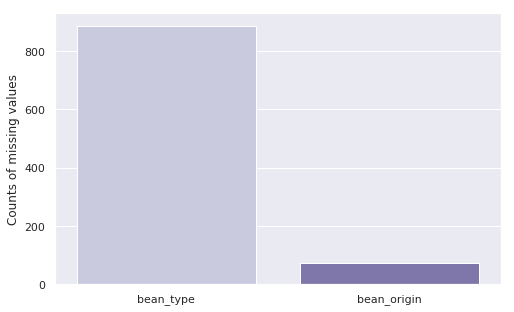

In [13]:
missing = data.isnull().sum()
missing = missing[missing > 0]

plt.figure(figsize=(8,5))
sns.barplot(x=missing.index, y=missing.values, palette="Purples")
plt.ylabel("Counts of missing values");

Ok, that's it.

## Exploring the flavours of chocolate... <a class="anchor" id="eda1"></a>

In this first exploratory data analysis I like to get an first intuition about the data. Perhaps we will gain some insights that may already help to understand what makes a chocolate bar tasty. I like to start with the important feature *rating* that I will use as a target for prediction later on. 

### What is given by the chocolate rating? <a class="anchor" id="rating"></a>

The dataset description says...

1. Unpleasant (Mostly unpalatable)
2. Disappointing
3. Satisfactory (3) to praiseworthy (3.5)
4. Premium
5. Elite

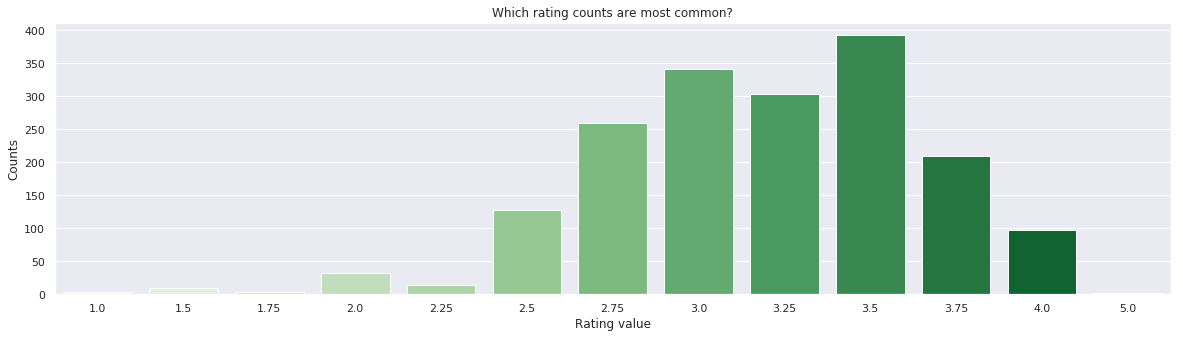

In [14]:
rating_counts = data.rating.value_counts()

plt.figure(figsize=(20,5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="Greens")
plt.xlabel("Rating value")
plt.ylabel("Counts")
plt.title("Which rating counts are most common?");

Crazy. The description says that we can find sublevels in the 3-rating category but as you can see they also appear for the 1 and 2 ratings and with more sublevels. I think it's not very useful to have such splittings in case of unpleasant chocolate bars. It should be sufficient to know that you can't enjoy the bar instead of knowing each subtle nuance of bad taste. 

In [15]:
def map_to_rating(l):
    if l <= 2:
        return 1
    elif 2 < l <= 2.5:
        return 2
    elif 2.5 < l <= 3:
        return 3
    elif 3 < l <= 3.5:
        return 4
    elif 3.5 < l <= 3.75:
        return 5
    else:
        return 6

In [16]:
data["new_rating"] = data.rating.apply(lambda l: map_to_rating(l))

### What bean types do we have? <a class="anchor" id="bean_types"></a>

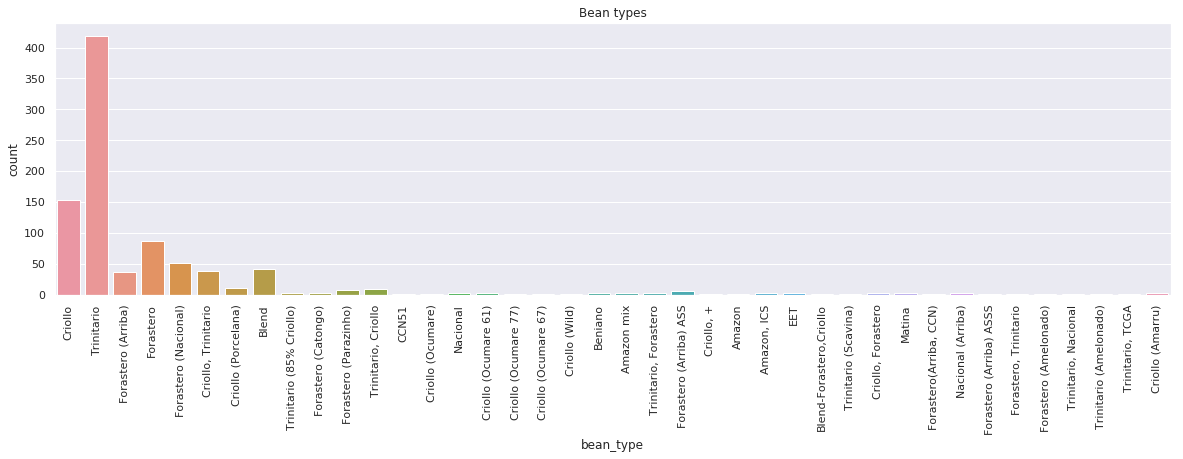

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(data.bean_type)
plt.xticks(rotation=90);
plt.title("Bean types");

Again, I feel astrong need to fuse bean types and turn them to something more general. In addition we know that we have a lot of missing values for the bean type. Let's check how many:

In [18]:
data.bean_type.isnull().value_counts() / len(data) * 100

False    50.529248
True     49.470752
Name: bean_type, dtype: float64

Ok, almost 50 % are missing. Now, we need to setup some strategy how to deal with the bean types. A first attempt could be to focus on the names that occur most often:

* Criollo
* Trinitario
* Forastero
* Amazon

In addition we can see that most chocolate bars have mixed bean types and we may create a feature that counts how many of these 4 bean types are included. 

In [19]:
def check_bean(l, name):
    l = l.lower()
    if name in l:
        return 1
    return 0

data["criollo_bean"] = data.bean_type.dropna().apply(lambda l: check_bean(l, "criollo"))
data["forastero_bean"] = data.bean_type.dropna().apply(lambda l: check_bean(l, "forastero"))
data["trinitario_bean"] = data.bean_type.dropna().apply(lambda l: check_bean(l, "trinitario"))
data["amazon_bean"] = data.bean_type.dropna().apply(lambda l: check_bean(l, "amazon"))

Now, we can easily sum up the number of bean types to describe a mixture in a chocolate bar. Besides that we should take into account that some bean type names are given by "blend". This name just tells us that we have a mixture of beans but there is no specification which kind of beans were used. Consequently it could be nice to create two more features:

* the number of different bean types in a bar
* if the bar contains a mixture (blend) or not

In [20]:
data["num_beans"] = data.loc[
    :,["criollo_bean", "forastero_bean", "trinitario_bean", "amazon_bean"]
].sum(axis=1)

In [21]:
blend_names = data.bean_type.dropna().apply(lambda l: np.where("blend" in l.lower(), 1, 0))
is_blend_idx = blend_names.loc[blend_names == 1].index.values

data["blend"] = 0
data.loc[(data.num_beans > 1) | (data.index.isin(is_blend_idx)), "blend"] = 1 

In addition it's useful to generate a feature that shows us if the bean type was missing:

In [22]:
data["missing_bean_type"] = np.where(data.bean_type.isnull()==True, 1, 0)
data.missing_bean_type.value_counts()

0    907
1    888
Name: missing_bean_type, dtype: int64

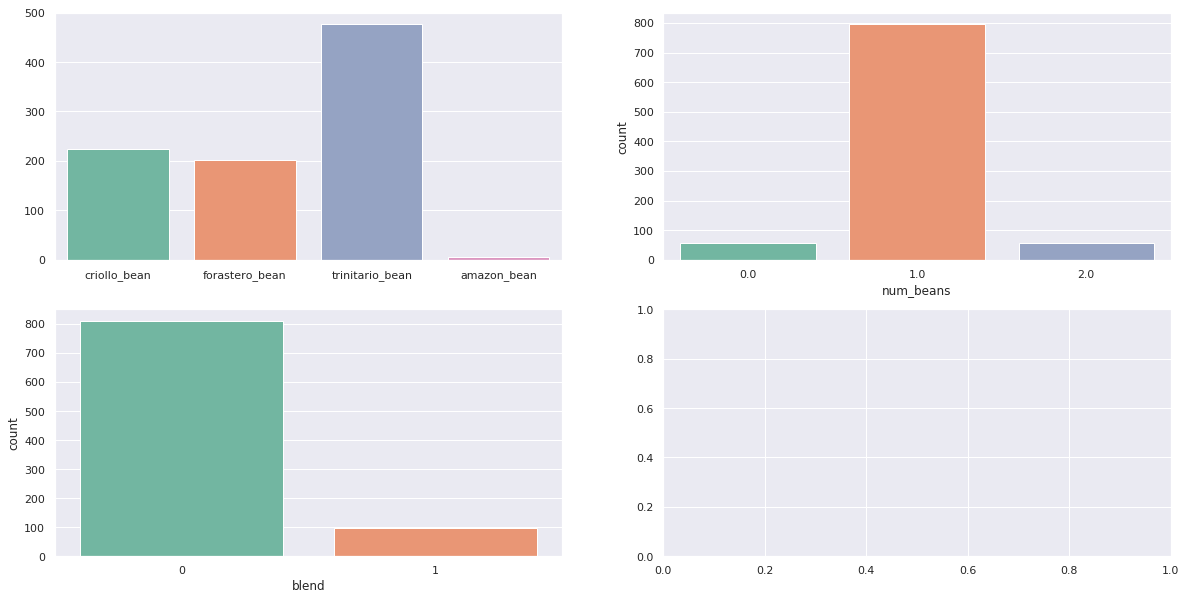

In [23]:
bean_type_counts = data.loc[
    :,["criollo_bean", "forastero_bean", "trinitario_bean", "amazon_bean"]
].sum(axis=0)

fig, ax = plt.subplots(2,2,figsize=(20,10))

sns.barplot(x=bean_type_counts.index, y=bean_type_counts.values, ax=ax[0,0], palette="Set2")
sns.countplot(data.loc[data.missing_bean_type==0].blend, ax=ax[1,0], palette="Set2");
sns.countplot(data.loc[data.missing_bean_type==0].num_beans, ax=ax[0,1], palette="Set2");

### Where do the beans come from? <a class="anchor" id="bean_origin"></a>

Ok, first of all, let's see how many different origins are mentioned for the cocoa beans:

In [24]:
len(data.bean_origin.unique())

100

Ok, that sounds not so much. But nonetheless we may have redundant information that tells us the same only in different words. 

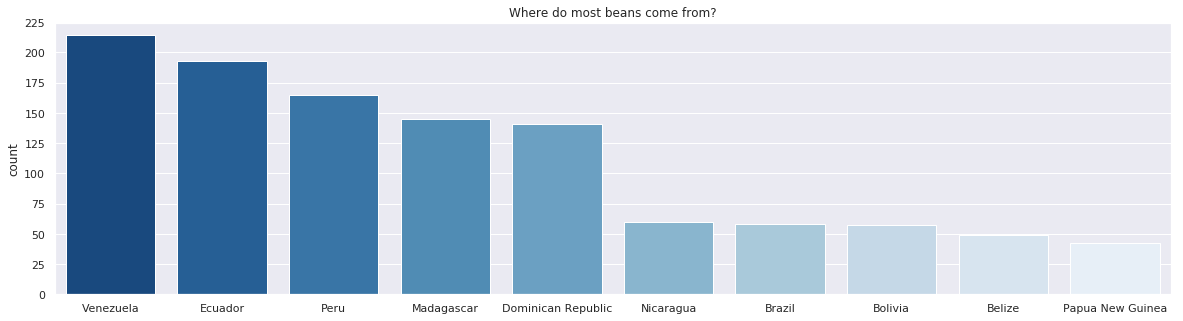

In [25]:
top_counts = data.bean_origin.value_counts().head(10)
sparse_counts = data.bean_origin.value_counts().tail(10)

plt.figure(figsize=(20,5))
sns.barplot(x=top_counts.index, y=top_counts.values, palette="Blues_r")
plt.title("Where do most beans come from?")
plt.ylabel("count");

In [26]:
sparse_counts

Martinique                   1
Ven., Indonesia, Ecuad.      1
Peru, Dom. Rep               1
Suriname                     1
Peru, Belize                 1
Africa, Carribean, C. Am.    1
Peru, Ecuador                1
Ven, Bolivia, D.R.           1
PNG, Vanuatu, Mad            1
Burma                        1
Name: bean_origin, dtype: int64

We can already see that we have some origins that can be easily fused with some of the top counts: Venezuela, Peru, Dominican Republic... To fuse categories it might be useful to know the distribution of value counts:

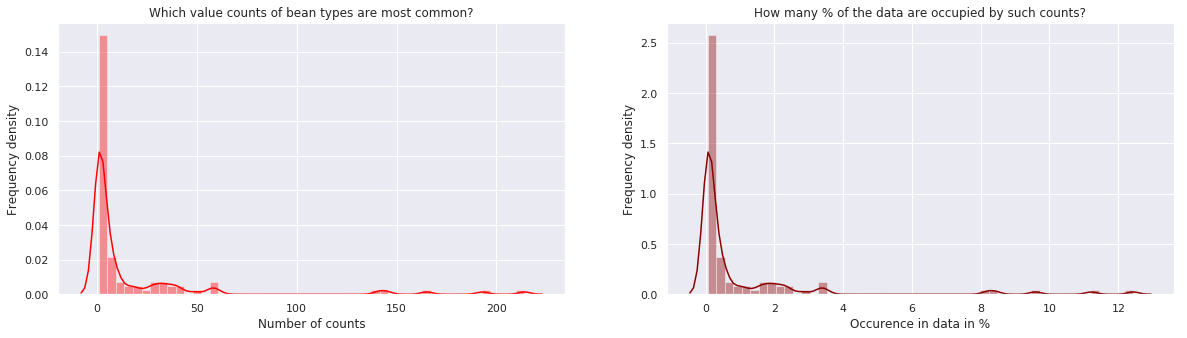

In [27]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(data.bean_origin.value_counts(), ax=ax[0], color="Red")
sns.distplot(data.bean_origin.value_counts() / data.bean_origin.count() * 100, ax=ax[1], color="darkred")
ax[0].set_xlabel("Number of counts");
ax[0].set_ylabel("Frequency density");
ax[0].set_title("Which value counts of bean types are most common?")
ax[1].set_xlabel("Occurence in data in %");
ax[1].set_ylabel("Frequency density");
ax[1].set_title("How many % of the data are occupied by such counts?");

#### Take-Away

* We can see that most of the origins have only a few counts. That confirms the need to fuse sparse bean type origins to gain more insights out of this data. Currently it contains too much detail to work with.
* Only a very few origins have counts greater than 50. From the figures above you can see that Nicaragua, Brazil, Bolivia, Belize and Papua New Guinea have all counts close to 50 and from the second subplot here you can see that each of them only cover around 3-4 % of the data. It's probably not very fruitful to include origins that have lower value counts. 

#### Stemming bean origins

Ok, we have seen that many words acutally mean the same: Take a look at Venezuela. You can find words like Ven that are likely to be an abbreviation of Venezuela. In addition we can see that we sometimes have multiple origins for one entry. I'm new to natural language processing but as my attempt of this kernel is to learn I like to try out some methods. :-)

This first is **stemming: It reduces a word to its root which is called stem**. Consequenly different words can have the same stem. In contrast to lemmatization this stem **need not be a valid word in the current language**. I think this technique could be useful for our problem. Let's try to find out, if it helps:

In [28]:
stemmer=LancasterStemmer()

def stem(l):
    tokenizer = RegexpTokenizer(r'\w+')
    token_words = tokenizer.tokenize(l)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

data["stemmed_bean_origin"] = data.dropna().bean_origin.apply(lambda l: stem(l))

Now, how many different bean origins are left?

In [29]:
len(data.stemmed_bean_origin.unique())

66

Jeha! We have turned 34 bean origins to some that are only named a bit differently. How does it look like for Venezuela?

In [30]:
data.dropna().groupby("stemmed_bean_origin").bean_origin.value_counts().tail(10)

stemmed_bean_origin  bean_origin            
vanuatu              Vanuatu                      7
ven indones ecuad    Ven., Indonesia, Ecuad.      1
ven trinidad mad     Ven., Trinidad, Mad.         1
venezuel             Venezuela                  139
venezuel carrib      Venezuela, Carribean         1
venezuel ghan        Venezuela, Ghana             1
                     Venezuela/ Ghana             1
venezuel jav         Venezuela, Java              1
vietnam              Vietnam                     37
west afric           West Africa                  6
Name: bean_origin, dtype: int64

Ok, only ven is not recognized well. Perhaps we will find a way to tackle that, but I think this is sufficient to start with.

In [31]:
vectorizer = CountVectorizer()
corpus = data.dropna().stemmed_bean_origin.values
word_counts = vectorizer.fit_transform(corpus)
word_counts.shape

(884, 65)

In [32]:
names = vectorizer.get_feature_names()

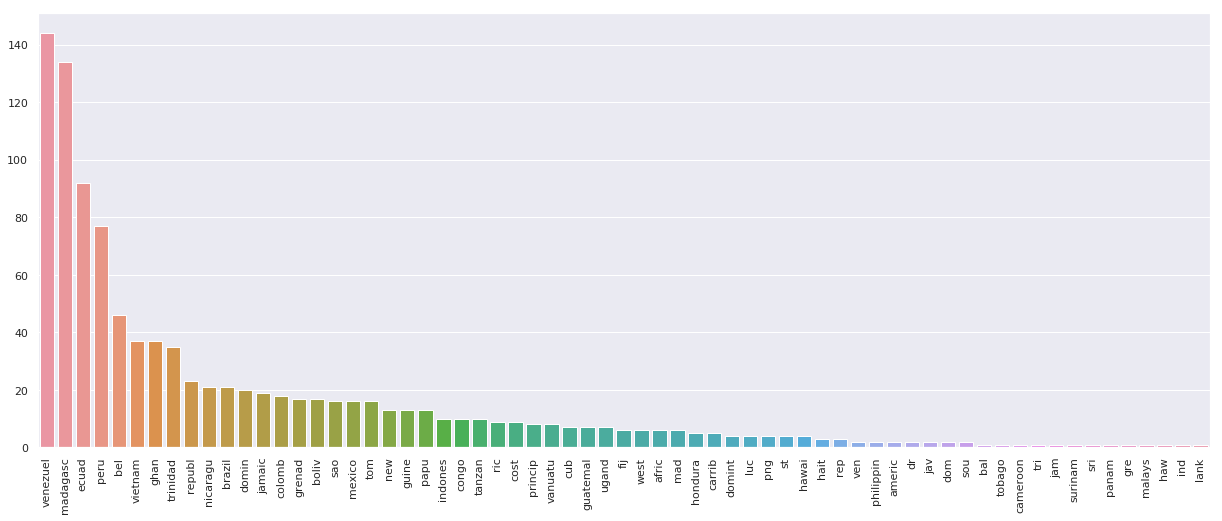

In [33]:
word_counts_df = pd.DataFrame(index=data.dropna().index.values, data=word_counts.toarray(), columns=names)
single_origin_counts = word_counts_df.sum().sort_values(ascending=False)


plt.figure(figsize=(21,8))
sns.barplot(single_origin_counts.index, single_origin_counts.values)
plt.xticks(rotation=90);

Take a look at papua new guinea: It was splitted into three parts - papu, new, guine. Consequently if we compute the total number of origins for one entry it would add 3 instead of 1. Let's try to rework this part. To find pairs that I'm not sure of, I like to use this kind of filter:

### Extracting bean origin codes

Work in progress

In [34]:
col = "papu"
viewer = word_counts_df[word_counts_df[col] == 1].sum()
viewer[viewer > 0]

guine    13
new      13
papu     13
dtype: int64

And to fuse words in a list:

In [35]:
def fuse_words(words):
    return np.where(word_counts_df.loc[:, words].sum(axis=1) == len(words), 1, 0)

Ok, let's start:

In [36]:
word_counts_df["domin_republ"] = fuse_words(["domin", "republ"])
word_counts_df["domint_republ"] = fuse_words(["domint", "republ"])
word_counts_df["dom_rep"] = fuse_words(["dom", "rep"])

word_counts_df["sao_tom"] = fuse_words(["sao", "tom"])
word_counts_df["papu_new_guine"] = fuse_words(["papu", "new", "guine"])
word_counts_df["cost_ric"] = fuse_words(["cost", "ric"])
word_counts_df["west_afric"] = fuse_words(["west", "afric"])
word_counts_df["st_luc"] = fuse_words(["st", "luc"])
word_counts_df["sou_americ"] = fuse_words(["sou", "americ"])
word_counts_df["sri_lank"] = fuse_words(["sri", "lank"])

word_counts_df = word_counts_df.drop(
    ["domin", "republ", "dom", "rep", "sao", "tom", "papu", "new", "guine",
     "cost", "ric", "west", "afric", "st", "luc", "sou", "americ", "domint",
     "sri", "lank"], axis=1)

Ok, finally there is one thing left: We should turn ven into venezuela and fuse all occurances of dominican republic:

In [37]:
def get_indices(col):
    return word_counts_df.loc[word_counts_df[col] == 1].index.values

In [38]:
word_counts_df.loc[get_indices("ven"), "venezuel"] = 1
word_counts_df.loc[get_indices("princip"), "sao_tom"] = 1
word_counts_df.loc[get_indices("png"), "papu_new_guine"] = 1
word_counts_df.loc[get_indices("jam"), "jamaic"] = 1
word_counts_df.loc[get_indices("gre"), "grenad"] = 1
word_counts_df.loc[get_indices("haw"), "hawai"] = 1
word_counts_df.loc[get_indices("mad"), "madagasc"] = 1

trinidad_index = set(get_indices("tri")).union(get_indices("tobago"))
word_counts_df.loc[trinidad_index, "trinidad"] = 1

domin_index = set(get_indices("domint_republ")).union(
    set(get_indices("dom_rep"))).union(
    get_indices("dr"))
word_counts_df.loc[domin_index, "domin_republ"] = 1


word_counts_df = word_counts_df.drop(
    ["ven", "domint_republ", "dom_rep", "dr",
     "princip", "tri", "tobago", "jam", "gre", 
     "haw", "png", "mad"], axis=1)

How many bean origins are left now?

In [39]:
len(word_counts_df.columns.values)

43

Great! We have clearly reduced the number of total bean origins from 66 to.... 

In [40]:
prepared_data = data.copy()
prepared_data.drop("bean_origin", axis=1, inplace=True)
prepared_data = prepared_data.join(word_counts_df)
prepared_data.head()

,company,bar_origin,review_update_value,review_pub_date,cocoa_percentage,company_location,rating,bean_type,new_rating,criollo_bean,forastero_bean,trinitario_bean,amazon_bean,num_beans,blend,missing_bean_type,stemmed_bean_origin,bal,bel,boliv,brazil,cameroon,carrib,colomb,congo,cub,ecuad,fij,ghan,grenad,guatemal,hait,hawai,hondura,ind,indones,jamaic,jav,madagasc,malays,mexico,nicaragu,panam,peru,philippin,surinam,tanzan,trinidad,ugand,vanuatu,venezuel,vietnam,domin_republ,sao_tom,papu_new_guine,cost_ric,west_afric,st_luc,sou_americ,sri_lank
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,NaN,5,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,NaN,3,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,NaN,3,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A. Morin,Akata,1680,2015,70.0,France,3.50,NaN,4,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,NaN,4,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
prepared_data.drop("stemmed_bean_origin", axis=1, inplace=True)

In [42]:
prepared_data.columns

Index(['company', 'bar_origin', 'review_update_value', 'review_pub_date',
       'cocoa_percentage', 'company_location', 'rating', 'bean_type',
       'new_rating', 'criollo_bean', 'forastero_bean', 'trinitario_bean',
       'amazon_bean', 'num_beans', 'blend', 'missing_bean_type', 'bal', 'bel',
       'boliv', 'brazil', 'cameroon', 'carrib', 'colomb', 'congo', 'cub',
       'ecuad', 'fij', 'ghan', 'grenad', 'guatemal', 'hait', 'hawai',
       'hondura', 'ind', 'indones', 'jamaic', 'jav', 'madagasc', 'malays',
       'mexico', 'nicaragu', 'panam', 'peru', 'philippin', 'surinam', 'tanzan',
       'trinidad', 'ugand', 'vanuatu', 'venezuel', 'vietnam', 'domin_republ',
       'sao_tom', 'papu_new_guine', 'cost_ric', 'west_afric', 'st_luc',
       'sou_americ', 'sri_lank'],
      dtype='object')

In [43]:
origin_names = {
    "venezuel": "VEN",
    "boliv": "BOL",
    "vietnam": "VNM",
    "sri_lank": "LKA",
    "st_luc": "LC",
    "cost_ric": "CR",
    "papu_new_guine": "PG",
    "sao_tom": "STP",
    "domint_republ": "DOM",
    "vanuatu": "VUT",
    "ugand": "UGA",
    "trinidad": "TTO",
    "tanzan": "TZA",
    "surinam": "SUR",
    "philippin": "PHL",
    "peru": "PER",
    "panam": "PAN",
    "nicaragu": "NIC",
    "mexico": "MEX",
    "malays": "MYS",
    "madagasc": "MDG",
    "jamaic": "JAM",
    "indones": "IDN",
    "ind": "IND",
    "hondura": "HND",
    "hait": "HTI",
    "guatemal": "GTM",
    "grenad": "GRD",
    "ghan": "GHA",
    "fij": "FJI",
    "ecuad": "ECU",
    "cub": "CUB",
    "congo": "COG",
    "colomb": "COL",
    "cameroon": "CMR",
    "brazil": "BRA",
    "bel": "BLZ",
    "carrib": "BQ",
    "bal": "Bali",
    "hawai": "Hawai",
    "jav": "Java"
}

#### Exploring the ratings of bean origins - Focusing on the top

To get started I like to focus on the most common, top 10, bean origins:

In [44]:
top_bean_origins = data.bean_origin.value_counts().head(20)

How much data is covered by these origins? How much data would we loose by skipping the others?

In [45]:
data.loc[data.bean_origin.isin(top_bean_origins.index),:].shape[0] / data.shape[0] * 100

80.83565459610028

Great! By focusing on the top 10 bean origins ... throwing the other away ... we still cover around 81 % of the data. Before I try to regain the lost information, let's explore if the quality of the chocolate is related to its bean origin. For this purpose I like to use folium. 

In [46]:
focus_data = data.loc[data.bean_origin.isin(top_bean_origins.index),:].copy()
bean_origin_ratings = focus_data.groupby("bean_origin").new_rating.mean()

In [47]:
geo_json_data = json.load(open("../input/python-folio-country-boundaries/world-countries.json"))

In [48]:
colormap = linear.YlGnBu_09.scale(
    bean_origin_ratings.min(),
    bean_origin_ratings.max())

used_names = []
def make_color(feature):
    current_country = feature['properties']['name']
    if current_country in bean_origin_ratings.index.values:
        used_names.append(current_country)
        return colormap(bean_origin_ratings[feature['properties']['name']])
    else:
        return "floralwhite"

In [49]:
m = folium.Map([0,0], zoom_start=1.5)

folium.GeoJson(
    geo_json_data,
    name='mean ratings of bean origin',
    style_function=lambda feature: {
        'fillColor': make_color(feature),
        'color': 'grey',
        'weight': 1,
        'dashArray': '3, 3',
        'fillOpacity': 0.8,
    }
).add_to(m)

colormap.caption = 'mean ratings of bean origin'
colormap.add_to(m)
folium.LayerControl().add_to(m)

m.save("bean_origin_ratings.html")
HTML('<iframe src=bean_origin_ratings.html width=800 height=450></iframe>')

 We can see that there are some origins of the top 10 that are more likely to yield a high quality chocolate bar. But which names were not used? (Have to fix this!)

In [50]:
set(bean_origin_ratings.index.values).difference(set(used_names))

{'Domincan Republic', 'Hawaii', 'Tanzania', 'Trinidad'}

### What is the specific geo region of a bean or chocolate bar? <a class="anchor" id="geo_region"></a>

### How much cocoa is contained in good chocolate? <a class="anchor" id="cocoa"></a>


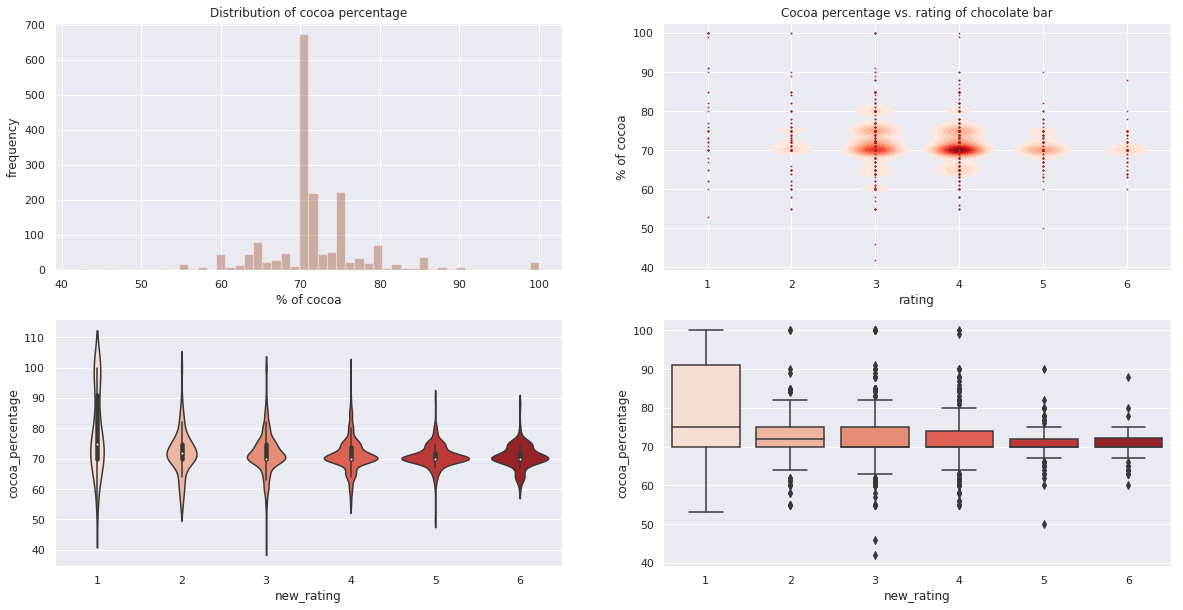

In [51]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

sns.distplot(data.cocoa_percentage, kde=False, color="sienna", ax=ax[0,0])
ax[0,0].set_xlabel("% of cocoa")
ax[0,0].set_ylabel("frequency")
ax[0,0].set_title("Distribution of cocoa percentage");

sns.kdeplot(data.new_rating, data.cocoa_percentage, cmap="Reds", shade=True, n_levels=20,
            shade_lowest=False, ax=ax[0,1]);
ax[0,1].scatter(data.new_rating, data.cocoa_percentage, s=0.5, c="Brown")
ax[0,1].set_ylabel("% of cocoa")
ax[0,1].set_xlabel("rating");
ax[0,1].set_title("Cocoa percentage vs. rating of chocolate bar");

sns.violinplot(x=data.new_rating, y=data.cocoa_percentage, ax=ax[1,0], palette="Reds")
sns.boxplot(x=data.new_rating, y=data.cocoa_percentage, ax=ax[1,1], palette="Reds");

Interestingly chocolate with very high % of cocoa have a tendency to be not delicious. This might be related to bitter compounds in cocoa. In addition we can see that the distributions or cocoa percentage become narrower with increasing rates. It seems that all good chocolate bars have cocoa percentages close to 70 %. 

** under construction ** 

### When were the ratings published and updated?  <a class="anchor" id="review_date"></a>

In [52]:
print("The first review was published {} and the last {}.".format(
    data.review_pub_date.min(), data.review_pub_date.max()))

The first review was published 2006 and the last 2017.


Huuh, 11 years are covered by the data. As ingredients of chocolate bars might have changed during this period we should consider the up-to-dateness of the review as well ;-) . In the dataset description we can see that this is related to the review_update_value (REF). The higher this value the more recent was the entry in the database:

## Predicting the chocolate rating with catboost <a class="anchor" id="catboost"></a>

**This part is heavily under construction and has currently nothing great to show**

I'm new to catboost and one reason to start this kernel was to get started with it and to explore it's features thereby practicing feature exploration and engineering of categorical data.

In [53]:
prepared_data.head()

,company,bar_origin,review_update_value,review_pub_date,cocoa_percentage,company_location,rating,bean_type,new_rating,criollo_bean,forastero_bean,trinitario_bean,amazon_bean,num_beans,blend,missing_bean_type,bal,bel,boliv,brazil,cameroon,carrib,colomb,congo,cub,ecuad,fij,ghan,grenad,guatemal,hait,hawai,hondura,ind,indones,jamaic,jav,madagasc,malays,mexico,nicaragu,panam,peru,philippin,surinam,tanzan,trinidad,ugand,vanuatu,venezuel,vietnam,domin_republ,sao_tom,papu_new_guine,cost_ric,west_afric,st_luc,sou_americ,sri_lank
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,NaN,5,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,NaN,3,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,NaN,3,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A. Morin,Akata,1680,2015,70.0,France,3.50,NaN,4,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,NaN,4,NaN,NaN,NaN,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
prepared_data["company"] = prepared_data["company"].astype("category")
prepared_data["bar_origin"] = prepared_data["bar_origin"].astype("category")
prepared_data["company_location"] = prepared_data["company_location"].astype("category")
prepared_data["bean_type"] = prepared_data["bean_type"].astype("category")
prepared_data["review_update_value"] = prepared_data["review_pub_date"].astype("category")

Ok, to get started, let's drop all missing values. I like to use some other models later that are able to fill in missing values... but at the moment just drop them ;-) ...

In [55]:
prepared_data.dropna(inplace=True)

to_drop = ["rating", "new_rating"]
X = prepared_data.drop(to_drop, axis=1).copy()
y = prepared_data.rating

In [56]:
cat_idx = []
for n in range(0, len(X.columns.values)):
    col = X.columns.values[n]
    col_type = X[col].dtype
    if col_type.name == "category":
        cat_idx.append(n)
print(len(cat_idx))

5


In [57]:
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=0)

In [58]:
train_pool = Pool(x_train.values, y_train.values, cat_features=cat_idx)
test_pool = Pool(x_test.values, y_test.values, cat_features=cat_idx)

In [59]:
model = CatBoostRegressor(iterations=50, 
                           depth=3, 
                           learning_rate=1, 
                           loss_function='RMSE', 
                           logging_level='Verbose')

In [60]:
model.fit(train_pool)

0:	learn: 0.4863206	total: 54.3ms	remaining: 2.66s
1:	learn: 0.4794149	total: 57.3ms	remaining: 1.38s
2:	learn: 0.4703812	total: 60.2ms	remaining: 943ms
3:	learn: 0.4508356	total: 64.1ms	remaining: 737ms
4:	learn: 0.4503500	total: 66.9ms	remaining: 602ms
5:	learn: 0.4499195	total: 70.5ms	remaining: 517ms
6:	learn: 0.4420148	total: 73.2ms	remaining: 450ms
7:	learn: 0.4360463	total: 75.6ms	remaining: 397ms
8:	learn: 0.4346046	total: 78.1ms	remaining: 356ms
9:	learn: 0.4200674	total: 81.1ms	remaining: 324ms
10:	learn: 0.4180782	total: 83.2ms	remaining: 295ms
11:	learn: 0.4147472	total: 85.5ms	remaining: 271ms
12:	learn: 0.4137619	total: 87.4ms	remaining: 249ms
13:	learn: 0.4130796	total: 89.5ms	remaining: 230ms
14:	learn: 0.4114418	total: 91.6ms	remaining: 214ms
15:	learn: 0.4105122	total: 93.7ms	remaining: 199ms
16:	learn: 0.4082990	total: 95.8ms	remaining: 186ms
17:	learn: 0.4074717	total: 98ms	remaining: 174ms
18:	learn: 0.4061420	total: 100ms	remaining: 164ms
19:	learn: 0.4058862	tota

In [61]:
# make the prediction using the resulting model
preds = model.predict(test_pool)
print(preds[0:10])

[3.19452879 3.44565698 2.75228859 3.20958821 3.0181572  3.3822438
 3.06083978 3.14939382 3.97516883 3.24149809]


In [62]:
y_test[0:10]

33      2.75
1337    3.00
134     3.00
405     3.75
1011    3.50
970     3.50
419     2.50
1426    2.75
1310    3.00
1070    3.75
Name: rating, dtype: float64

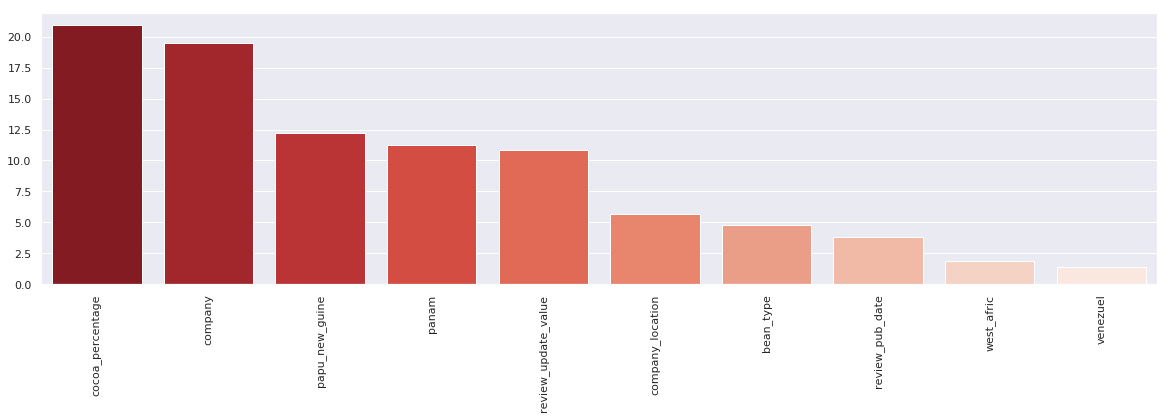

In [63]:
importances = model.get_feature_importance()
best_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(20,5))
sns.barplot(x=X.columns.values[best_idx], y=np.array(importances)[best_idx], palette="Reds_r")
plt.xticks(rotation=90);